In [1]:
from datasets import load_dataset, concatenate_datasets
import json

In [2]:
import json
from datasets import Dataset

def normalize(example):
    # Add tools column if missing
    if "tools" not in example:
        example["tools"] = "null"

    # Normalize conversations so each dict has tool_calls
    for msg in example["conversations"]:
        if "tool_calls" not in msg:
            msg["tool_calls"] = "null"
    return example

### lima

In [3]:
ds_lima=load_dataset("habanoz/lima-chat-format")['train']

In [5]:
ds_lima

Dataset({
    features: ['category', 'conversation'],
    num_rows: 1030
})

In [6]:
ds_lima = ds_lima.rename_column("conversation","conversations").remove_columns(["category"]).map(normalize)
ds_lima

Map:   0%|          | 0/1030 [00:00<?, ? examples/s]

Dataset({
    features: ['conversations', 'tools'],
    num_rows: 1030
})

### xlam

In [14]:
ds_xlam=load_dataset("Salesforce/xlam-function-calling-60k")['train']

In [15]:
ds_xlam

Dataset({
    features: ['id', 'query', 'answers', 'tools'],
    num_rows: 60000
})

In [16]:
ds_xlam[0]

{'id': 0,
 'query': 'Where can I find live giveaways for beta access and games?',
 'answers': '[{"name": "live_giveaways_by_type", "arguments": {"type": "beta"}}, {"name": "live_giveaways_by_type", "arguments": {"type": "game"}}]',
 'tools': '[{"name": "live_giveaways_by_type", "description": "Retrieve live giveaways from the GamerPower API based on the specified type.", "parameters": {"type": {"description": "The type of giveaways to retrieve (e.g., game, loot, beta).", "type": "str", "default": "game"}}}]'}

In [17]:
ds_xlam = ds_xlam.map(lambda x: {'conversations': [  {'role':'user','content':x['query']}, {'role':'assistant','content':"", "tool_calls": x['answers'] } ] })

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

In [18]:
ds_xlam[0]

{'id': 0,
 'query': 'Where can I find live giveaways for beta access and games?',
 'answers': '[{"name": "live_giveaways_by_type", "arguments": {"type": "beta"}}, {"name": "live_giveaways_by_type", "arguments": {"type": "game"}}]',
 'tools': '[{"name": "live_giveaways_by_type", "description": "Retrieve live giveaways from the GamerPower API based on the specified type.", "parameters": {"type": {"description": "The type of giveaways to retrieve (e.g., game, loot, beta).", "type": "str", "default": "game"}}}]',
 'conversations': [{'content': 'Where can I find live giveaways for beta access and games?',
   'role': 'user',
   'tool_calls': None},
  {'content': '',
   'role': 'assistant',
   'tool_calls': '[{"name": "live_giveaways_by_type", "arguments": {"type": "beta"}}, {"name": "live_giveaways_by_type", "arguments": {"type": "game"}}]'}]}

In [19]:
ds_xlam= ds_xlam.remove_columns(["id","query","answers"])
ds_xlam

Dataset({
    features: ['tools', 'conversations'],
    num_rows: 60000
})

In [20]:
ds_xlam = ds_xlam.shuffle(122).select(range(2000))
ds_xlam

Dataset({
    features: ['tools', 'conversations'],
    num_rows: 2000
})

## Culter TR

In [21]:
ds_cultur_tr = load_dataset("habanoz/cultur_articles_tr")['train'].rename_column("conversation","conversations").map(normalize)
ds_cultur_tr

Map:   0%|          | 0/8430 [00:00<?, ? examples/s]

Dataset({
    features: ['conversations', 'tools'],
    num_rows: 8430
})

## Wildchat TR

In [22]:
wildchattr_10k_ds = load_dataset("habanoz/WildChat-turkce-cleaned")['train'].rename_column("conversation","conversations").map(normalize)
wildchattr_10k_ds

Map:   0%|          | 0/5838 [00:00<?, ? examples/s]

Dataset({
    features: ['conversations', 'tools'],
    num_rows: 5838
})

## Finetome

In [23]:
finetome100k_10k_ds = load_dataset("habanoz/FineTome-10k-dedup-clean")['train'].map(normalize)
finetome100k_10k_ds

Dataset({
    features: ['conversations', 'tools'],
    num_rows: 10000
})

In [24]:
finetome100k_10k_ds[0]

{'conversations': [{'content': 'What is the current flowing in a circular loop of radius r if two protons, each carrying a charge q, are moving along the loop with a constant speed v? The protons are always positioned at diametrically opposite ends and complete one revolution around the center in a time t, where t = 2πr/v.',
   'role': 'user',
   'tool_calls': 'null'},
  {'content': 'The current in the loop can be calculated using the net charge passing a given point on the loop per unit time. Since there are two protons moving in opposite directions, whenever one proton passes a point, the other proton is simultaneously passing the diametrically opposite point, thus contributing its charge in the opposite direction. As a result, the net charge passing any point on the loop in time t is $2q$. Therefore, the current in the loop, denoted by I, is given by the equation:\n\\[ I = \\frac{2q}{t} \\]',
   'role': 'assistant',
   'tool_calls': 'null'}],
 'tools': 'null'}

## Travel Function Calls

In [25]:
travel_function_call_ds = load_dataset("habanoz/travel_function_call_dataset")['train']


In [27]:
travel_function_call_ds[0]

{'question': "Tokyo'da gezilecek en iyi 7 yeri öğrenebilir miyim?",
 'function_calls': '[{"name": "list_attractions", "arguments": {"city": "Tokyo", "limit": 7}}]',
 'available_functions': '[{"name": "list_attractions", "description": "List top attractions for the given city. Returns an array of attraction objects (name, address, shortDescription, rating, category).", "parameters": {"type": "object", "properties": {"city": {"type": "string", "description": "City name or query (e.g., \'Paris, France\' or \'Seattle, WA\')."}, "limit": {"type": "integer", "description": "Maximum number of attractions to return.", "minimum": 1, "default": 10}}, "required": ["city"]}}, {"name": "search_hotel", "description": "Search for hotels for the given check-in/check-out dates and number of guests. Returns an array of hotel objects (name, address, rating, availableRooms, price {amount, currency}, bookingUrl). Dates should be ISO 8601 (YYYY-MM-DD).", "parameters": {"type": "object", "properties": {"chec

In [28]:
travel_function_call_ds = travel_function_call_ds.map(lambda x: {'conversations': [  {'role':'user','content':x['question']}, {'role':'assistant','content':"", "tool_calls": x['function_calls'] } ] }).rename_column("available_functions","tools").remove_columns(['question', 'function_calls'])
travel_function_call_ds

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Dataset({
    features: ['tools', 'conversations'],
    num_rows: 236
})

In [29]:
travel_function_call_ds[1]

{'tools': '[{"name": "search_flight", "description": "Search for round-trip flights for the given dates and number of passengers. Returns an array of flight objects (airline, flightNumber, departureDateTime, arrivalDateTime, duration, stops, price {amount, currency}, bookingUrl). Dates should be ISO 8601 (YYYY-MM-DD).", "parameters": {"type": "object", "properties": {"departureDate": {"type": "string", "description": "Outbound departure date in YYYY-MM-DD (ISO 8601).", "format": "date"}, "returnDate": {"type": "string", "description": "Return date in YYYY-MM-DD (ISO 8601).", "format": "date"}, "passengers": {"type": "integer", "description": "Number of passengers (integer >= 1).", "minimum": 1}}, "required": ["departureDate", "returnDate", "passengers"]}}, {"name": "search_web", "description": "Search the web for the given query. Returns an array of result strings (title + URL).", "parameters": {"type": "object", "properties": {"query": {"type": "string", "description": "Search query t

## Planning Dataset

In [31]:
planning_ds = load_dataset("habanoz/planning_dataset_v1")['train']
planning_ds

Generating train split:   0%|          | 0/996 [00:00<?, ? examples/s]

Dataset({
    features: ['conversations'],
    num_rows: 996
})

In [33]:
planning_ds = planning_ds.map(normalize)

Map:   0%|          | 0/996 [00:00<?, ? examples/s]

In [35]:
print("Lima", len(ds_lima))
print("Culter TR", len(ds_cultur_tr))
print("Wildchat TR-cleaned", len(wildchattr_10k_ds))
print("Finetome100k-cleaned", len(finetome100k_10k_ds))
print("Travel function call", len(travel_function_call_ds))
print("Xlam function call", len(ds_xlam))
print("Planning", len(planning_ds))


print("Total", len(ds_lima)+len(ds_xlam)+len(ds_cultur_tr)+len(wildchattr_10k_ds)+len(finetome100k_10k_ds)+len(travel_function_call_ds) + len(planning_ds))

Lima 1030
Culter TR 8430
Wildchat TR-cleaned 5838
Finetome100k-cleaned 10000
Travel function call 236
Xlam function call 2000
Planning 996
Total 28530


## Combine

In [41]:
ds_final = concatenate_datasets([ds_lima, ds_cultur_tr, wildchattr_10k_ds, finetome100k_10k_ds, travel_function_call_ds,  ds_xlam, planning_ds])
ds_final

Dataset({
    features: ['conversations', 'tools'],
    num_rows: 28530
})

In [ ]:
ds_final.push_to_hub("habanoz/finetune_mix_v1", private=False, token="")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/29 [00:00<?, ?ba/s]

Uploading files as a binary IO buffer is not supported by Xet Storage. Falling back to HTTP upload.


CommitInfo(commit_url='https://huggingface.co/datasets/habanoz/finetune_mix_v1/commit/463a34a021e4abffac4daa9d4461109e2bf659aa', commit_message='Upload dataset', commit_description='', oid='463a34a021e4abffac4daa9d4461109e2bf659aa', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/habanoz/finetune_mix_v1', endpoint='https://huggingface.co', repo_type='dataset', repo_id='habanoz/finetune_mix_v1'), pr_revision=None, pr_num=None)

## Stats

In [37]:
ds_final = concatenate_datasets([ds_lima, ds_cultur_tr, wildchattr_10k_ds, finetome100k_10k_ds, planning_ds])

In [38]:
ds_final

Dataset({
    features: ['conversations', 'tools'],
    num_rows: 26294
})

Total conversations: 26294
Average turns per conversation: 3.33
Max turns in a conversation: 116
Min turns in a conversation: 2
p90: 5.0
Average user message length (words): 113.74
Average assistant message length (words): 186.46


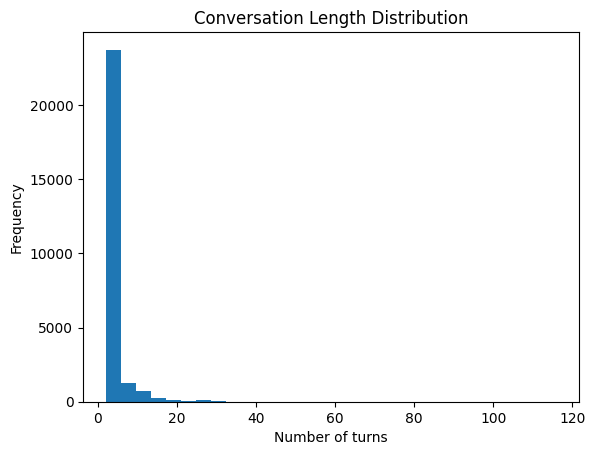

In [39]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

dataset = ds_final
# --- General stats ---
num_conversations = len(dataset)

# Conversation lengths (number of turns)
conv_lengths = [len(conv) for conv in dataset["conversations"]]

avg_turns = np.mean(conv_lengths)
max_turns = np.max(conv_lengths)
min_turns = np.min(conv_lengths)
p90 = np.percentile(conv_lengths, 90)

# Count user vs assistant messages and message lengths
user_msg_lengths, assistant_msg_lengths = [], []
for conv in dataset["conversations"]:
    for turn in conv:
        role = turn.get("role", "")
        text = turn.get("content", "")
        if role == "user":
            user_msg_lengths.append(len(text.split()))
        elif role == "assistant":
            assistant_msg_lengths.append(len(text.split()))

avg_user_len = np.mean(user_msg_lengths)
avg_assistant_len = np.mean(assistant_msg_lengths)

# --- Print stats ---
print(f"Total conversations: {num_conversations}")
print(f"Average turns per conversation: {avg_turns:.2f}")
print(f"Max turns in a conversation: {max_turns}")
print(f"Min turns in a conversation: {min_turns}")
print(f"p90: {p90}")
print(f"Average user message length (words): {avg_user_len:.2f}")
print(f"Average assistant message length (words): {avg_assistant_len:.2f}")

# --- Plot distribution of conversation lengths ---
plt.hist(conv_lengths, bins=30)
plt.xlabel("Number of turns")
plt.ylabel("Frequency")
plt.title("Conversation Length Distribution")
plt.show()

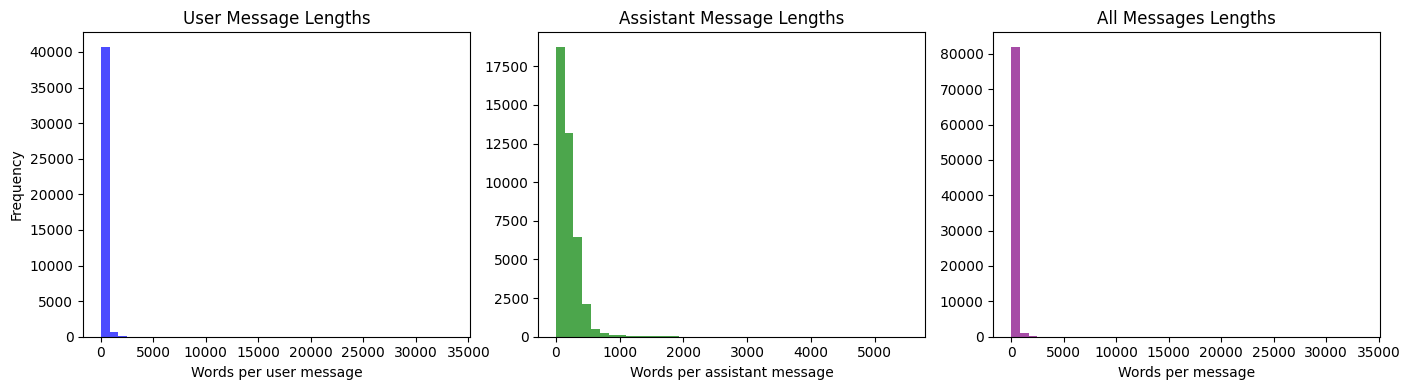

In [40]:
all_msg_lengths = user_msg_lengths + assistant_msg_lengths

# --- Plot histograms ---
plt.figure(figsize=(14, 4))

# User messages
plt.subplot(1, 3, 1)
plt.hist(user_msg_lengths, bins=40, alpha=0.7, color="blue")
plt.xlabel("Words per user message")
plt.ylabel("Frequency")
plt.title("User Message Lengths")

# Assistant messages
plt.subplot(1, 3, 2)
plt.hist(assistant_msg_lengths, bins=40, alpha=0.7, color="green")
plt.xlabel("Words per assistant message")
plt.title("Assistant Message Lengths")

# Combined
plt.subplot(1, 3, 3)
plt.hist(all_msg_lengths, bins=40, alpha=0.7, color="purple")
plt.xlabel("Words per message")
plt.title("All Messages Lengths")

plt.tight_layout()
plt.show()